In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import itertools
import bs4 as bs
import requests
import datetime as dt
from datetime import datetime, timedelta
import time
import timeit
import os
import pandas_datareader.data as pdr
from math import sqrt
import operator
from functools import reduce
import joblib
import pickle

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [2]:
%matplotlib inline

In [3]:
# !pip install pmdarima
# !pip install yfinance
# !pip install optuna

In [4]:
import yfinance as yf
import pmdarima as pm
from pmdarima.arima import AutoARIMA
from pmdarima.arima import ndiffs

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
# pd.set_option('max_columns', None)

In [7]:
# !wget -q https://raw.githubusercontent.com/aazaozerskaia/Stock_Price_Prediction/main/utils/parser_yf.py
# !wget -q https://raw.githubusercontent.com/aazaozerskaia/Stock_Price_Prediction/main/utils/preprocessing.py
# !wget -q https://raw.githubusercontent.com/aazaozerskaia/Stock_Price_Prediction/main/utils/feature_engineering.py
# !wget -q https://raw.githubusercontent.com/aazaozerskaia/Stock_Price_Prediction/main/utils/ts_features.py  
# !wget -q https://raw.githubusercontent.com/aazaozerskaia/Stock_Price_Prediction/main/utils/LSTM_ts_loaders.py

## Collecting data

In [6]:
from parser_yf import data_collection

In [9]:
url = 'http://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
df_raw = data_collection(url).get_all_data()

n_unique = df_raw['symbol'].nunique()
assert n_unique  == 503, f'Missing : {(503-n_unique )}'

[*********************100%***********************]  1 of 1 completed


100%|██████████| 502/502 [08:46<00:00,  1.05s/it]


In [10]:
df_raw.to_csv('sp500_raw.csv', index=False)

In [11]:
# with gzip.open("sp500_raw1.gz", "wb") as f:
#     pickle.dump(df_raw[df_raw['date']<='2016-12-31'], f)

# with gzip.open("sp500_raw2.gz", "wb") as f:
#     pickle.dump(df_raw[df_raw['date']>'2016-12-31'], f)

In [12]:
# check if passing a list
# p = data_collection()
# p.collect_yf_data(tickers=['AAPL', 'NVR'])

## Data Analysis

S&P 500 index

In [7]:
snp = yf.download('%5EGSPC', start='2010-01-01', end='2023-03-31')
snp.columns = snp.columns.str.lower()

[*********************100%***********************]  1 of 1 completed


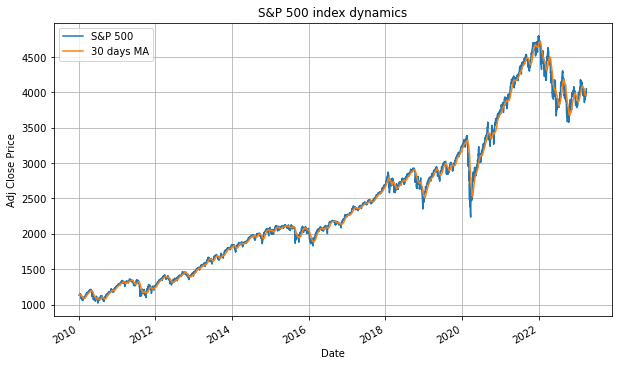

In [8]:
plt.figure(figsize=(10,6))
snp['adj close'].plot(ylabel='Adj Close Price')
snp['adj close'].rolling('30D').mean().plot()
plt.grid(True)
plt.title('S&P 500 index dynamics')
plt.legend(['S&P 500', '30 days MA'])
plt.show();

_____________________________________________________________________________________________________

In [10]:
df = pd.read_csv('sp500_raw.csv', parse_dates=['date'])
# df = df_raw.copy()

In [11]:
df.head()

,date,open,high,low,close,adj close,volume,symbol,gics sector,gics sub-industry
0,2013-02-01,31.50,31.74,30.469999,31.010000,28.823187,66789100,ZTS,Health Care,Pharmaceuticals
1,2013-02-04,31.09,31.99,30.760000,31.020000,28.832491,7695400,ZTS,Health Care,Pharmaceuticals
2,2013-02-05,31.25,31.98,30.850000,31.040001,28.851086,5013200,ZTS,Health Care,Pharmaceuticals
3,2013-02-06,30.98,31.43,30.750000,31.030001,28.841791,2126100,ZTS,Health Care,Pharmaceuticals
4,2013-02-07,31.00,32.73,31.000000,32.000000,29.743387,3800800,ZTS,Health Care,Pharmaceuticals


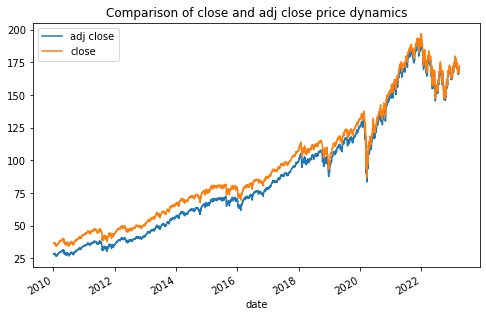

In [12]:
df.pivot_table(index='date', values=['close', 'adj close'], aggfunc='mean').plot(figsize=(8,5))
plt.title('Comparison of close and adj close price dynamics');

In [13]:
cols = ['open', 'high', 'low', 'close', 'adj close', 'volume']
df[cols].describe().T

,count,mean,std,min,25%,50%,75%,max
open,1604975.0,9.679858e+01,1.738210e+02,0.70,34.610001,6.000000e+01,1.061300e+02,5.977610e+03
high,1604975.0,9.789332e+01,1.760530e+02,0.71,35.000000,6.065000e+01,1.072900e+02,5.982450e+03
low,1604975.0,9.568219e+01,1.716186e+02,0.65,34.209999,5.937238e+01,1.050000e+02,5.884060e+03
close,1604975.0,9.681545e+01,1.738796e+02,0.70,34.619999,6.002500e+01,1.061700e+02,5.959330e+03
adj close,1604975.0,8.966282e+01,1.737617e+02,0.70,28.874742,5.197425e+01,9.668340e+01,5.959330e+03
volume,1604975.0,5.898603e+06,2.028025e+07,0.00,991500.000000,2.130200e+06,4.866200e+06,1.880998e+09


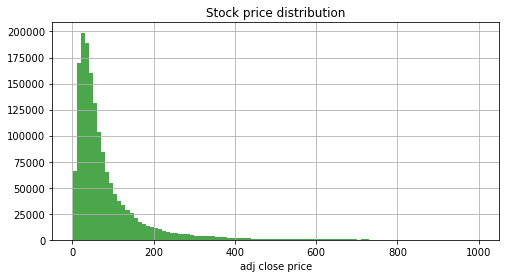

In [14]:
df.loc[(df['adj close'] < 1000), 'adj close'].hist(bins=100, figsize=(8,4), color='g', alpha=0.7);
plt.title('Stock price distribution');
plt.xlabel('adj close price');

In [15]:
df['capital'] = df['adj close'] * df['volume']

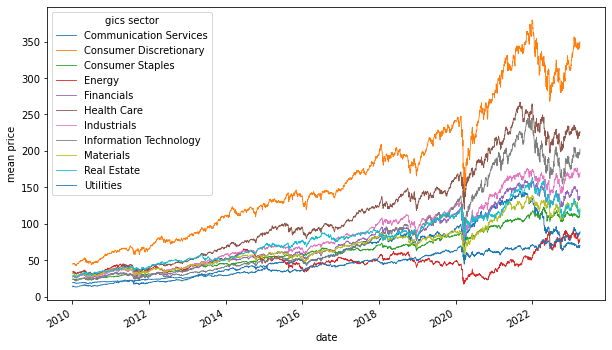

In [16]:
df.pivot_table(index='date', columns='gics sector', values='adj close', aggfunc='mean').plot(figsize=(10,6), linewidth=0.85)
plt.ylabel('mean price');

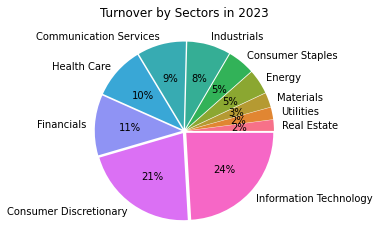

In [17]:
sec_gr = df[df['date'] >= '2023-01-01'].groupby('gics sector').agg(capital=('capital', 'sum')
                                                                    ).reset_index().sort_values(by='capital')
plt.pie(x=sec_gr['capital'], labels=sec_gr['gics sector'], 
        autopct='%1.0f%%', colors=sns.color_palette("husl",11), explode=[0.03]*len(sec_gr));
plt.title('Turnover by Sectors in 2023');

In [18]:
print('Number of unique companies by sectors')
df.groupby(['gics sector', 'symbol']).agg(cnt=('symbol', 'count')).reset_index()['gics sector'].value_counts()

Number of unique companies by sectors


Industrials               74
Financials                72
Information Technology    66
Health Care               65
Consumer Discretionary    53
Consumer Staples          37
Real Estate               30
Utilities                 30
Materials                 29
Communication Services    24
Energy                    23
Name: gics sector, dtype: int64

In [19]:
# gr = dff.groupby(['date', 'gics sector']).agg(sold_sum=('capital', 'sum'), 
#                                               sold_vol=('volume', 'sum'),
#                                               avg_adj_close=('adj close', 'mean')
#                                               ).reset_index().set_index(keys='date')
# gr['w_avg_adj_close'] = gr['sold_sum']/gr['sold_vol']
# sec = gr[['gics sector', 'avg_adj_close']]

# for sec in sorted(gr['gics sector'].unique()):
#     gr.loc[gr['gics sector']==sec, 'w_avg_adj_close'].plot(figsize=(8,4))
#     gr.loc[gr['gics sector']==sec, 'avg_adj_close'].plot(figsize=(8,4))
#     plt.legend()
#     plt.title(f'{sec} dynamics')
#     plt.ylabel('avg price');
#     plt.show()

In [20]:
# Companies ranked by Market Cap by sectors
comp = df.groupby(['gics sector', 'symbol'])['capital'].sum()
largest_comp = comp.loc[comp.groupby(level=0).idxmax()].reset_index().sort_values(by='capital').reset_index(drop=True)
largest_comp

,gics sector,symbol,capital
0,Real Estate,AMT,8.626016e+11
1,Utilities,NEE,9.636375e+11
2,Materials,FCX,1.545050e+12
3,Consumer Staples,PG,2.304472e+12
4,Health Care,PFE,2.615476e+12
5,Energy,XOM,3.307342e+12
6,Industrials,BA,4.150501e+12
7,Financials,BAC,5.272510e+12
8,Communication Services,META,1.019797e+13
9,Consumer Discretionary,TSLA,2.063828e+13


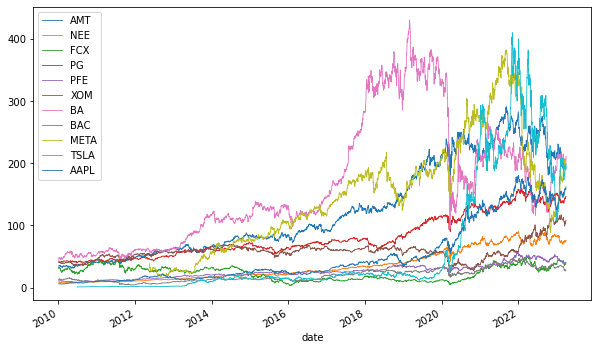

In [21]:
for symb in largest_comp['symbol'].tolist():
    a = df[df['symbol'] == symb].set_index(keys='date')
    a['adj close'].plot(figsize=(10,6), linewidth=0.85)
plt.legend(largest_comp['symbol'].tolist());
plt.title('');

In [22]:
# rows count by ticker
df['symbol'].value_counts().tail(10)

MRNA    1085
FOXA    1022
FOX     1021
DOW     1016
CTVA     970
OTIS     764
CARR     764
OGN      473
CEG      301
GEHC      72
Name: symbol, dtype: int64

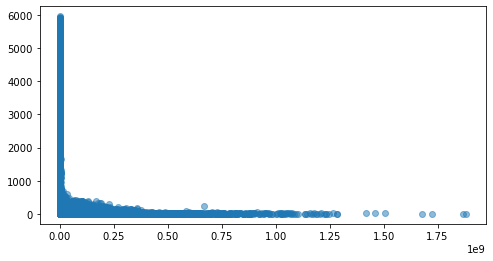

In [23]:
# Correlation plot between volume and price
plt.figure(figsize=(8,4))
plt.scatter(df['volume'], df['adj close'], alpha=0.5);

## Data preprocessing and Feature engineering 

In [24]:
from preprocessing import data_preprocessing 
from feature_engineering import feature_engineering
from ts_features import ts_features

In [25]:
%%time

categorical_cols = ['symbol', 'gics sector', 'gics sub-industry']
dff = data_preprocessing(df).preprocessing_steps()

fe = feature_engineering(dff, cat_features=categorical_cols)
dff = fe.get_data()
enc_dict = fe.get_enc_dict()

dff = ts_features(dff, y='adj close', lag_orders=[7], ma_windows=[7]).add_features()
dff = ts_features(dff, y='adj close_norm', lag_orders=[7], ma_windows=[7]).add_features()

CPU times: user 1min 32s, sys: 979 ms, total: 1min 33s
Wall time: 1min 33s


In [26]:
dff.head(3)

,date,open,high,low,close,adj close,volume,symbol,gics sector,gics sub-industry,...,year,month,day,adj close_norm,lag_7_adj close,ma_7_adj close,ma_7_lag_adj close,lag_7_adj close_norm,ma_7_adj close_norm,ma_7_lag_adj close_norm
0,2013-02-01,31.50,31.74,30.469999,31.010000,28.823187,66789100,502,5,98,...,2013,2,32,0.004720,0.0,28.823187,0.0,0.0,0.004720,0.0
1,2013-02-04,31.09,31.99,30.760000,31.020000,28.832491,7695400,502,5,98,...,2013,2,35,0.004721,0.0,28.827839,0.0,0.0,0.004721,0.0
2,2013-02-05,31.25,31.98,30.850000,31.040001,28.851086,5013200,502,5,98,...,2013,2,36,0.004724,0.0,28.835588,0.0,0.0,0.004722,0.0


## Experiments

In [27]:
def evaluate_res(predictions, actual) -> dict:
    '''Calculate metrics'''
    metrics_dict = {}
    metrics_dict['RMSE'] = round(sqrt(mean_squared_error(actual, predictions)), 3)
    metrics_dict['MAE'] = round(mean_absolute_error(actual, predictions), 3)
    metrics_dict['MAPE'] = round(mean_absolute_percentage_error(actual, predictions), 3)
    return metrics_dict

In [28]:
days = ['2023-03-01', '2023-03-02', '2023-03-03', '2023-03-06', '2023-03-07', '2023-03-08', '2023-03-09']
days2 = ['2023-03-10', '2023-03-13', '2023-03-14', '2023-03-15', '2023-03-16', '2023-03-17', '2023-03-20']

#### Predictions with MA and Lags

In [29]:
true_vals = dff.loc[dff['date']>='2023-03-01', ['date', 'adj close']]
true_mean = true_vals.groupby('date').agg(true_mean=('adj close', 'mean'))

ma_vals = dff.loc[dff['date']>='2023-03-01', ['date', 'ma_7_lag_adj close']]
ma_mean = ma_vals.groupby('date').agg(ma_mean=('ma_7_lag_adj close', 'mean'))

lagged_vals = dff.loc[dff['date']>='2023-03-01', ['date', 'lag_7_adj close']]
lagged_mean = lagged_vals.groupby('date').agg(lag_mean=('lag_7_adj close', 'mean'))

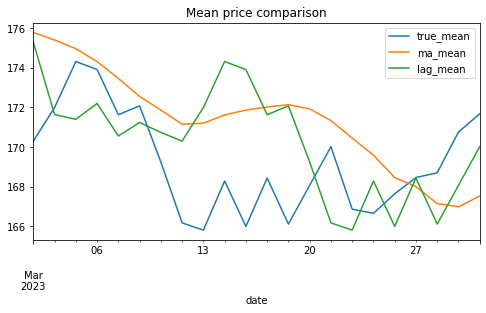

In [30]:
means = true_mean
means['ma_mean'] = ma_mean
means['lag_mean'] = lagged_mean

means.plot(figsize=(8,4))
plt.title('Mean price comparison')
plt.show();

In [31]:
df_ma_lag = true_vals.set_index(keys=['date'])
df_ma_lag['ma_vals'] = ma_vals.set_index(keys=['date'])
df_ma_lag['lagged_vals'] = lagged_vals.set_index(keys=['date'])

In [32]:
results_ma = []
for d in days:
    results_ma.append(evaluate_res(df_ma_lag[df_ma_lag.index <= d]['adj close'], 
                                   df_ma_lag[df_ma_lag.index <= d]['ma_vals']))
    
print('Moving Avarage with shift')
print(evaluate_res(ma_vals['ma_7_lag_adj close'], true_vals['adj close']))
display(pd.DataFrame(data=results_ma, index=days).T)

Moving Avarage with shift
{'RMSE': 13.717, 'MAE': 6.422, 'MAPE': 0.048}


,2023-03-01,2023-03-02,2023-03-03,2023-03-06,2023-03-07,2023-03-08,2023-03-09
RMSE,14.636,14.071,13.933,13.681,13.765,13.944,13.867
MAE,7.286,6.837,6.397,6.078,6.025,5.902,5.865
MAPE,0.043,0.040,0.037,0.035,0.035,0.035,0.035


In [33]:
results_lag = []
for d in days:
    results_lag.append(evaluate_res(df_ma_lag[df_ma_lag.index <= d]['adj close'], 
                                   df_ma_lag[df_ma_lag.index <= d]['lagged_vals']))

print('7 days lags')
print(evaluate_res(lagged_vals['lag_7_adj close'], true_vals['adj close']))
display(pd.DataFrame(data=results_lag, index=days).T)

7 days lags
{'RMSE': 12.553, 'MAE': 5.631, 'MAPE': 0.04}


,2023-03-01,2023-03-02,2023-03-03,2023-03-06,2023-03-07,2023-03-08,2023-03-09
RMSE,14.476,14.385,14.717,14.135,13.786,13.489,13.021
MAE,6.926,6.020,5.872,5.486,5.320,5.179,5.074
MAPE,0.040,0.035,0.033,0.031,0.031,0.030,0.030


### ARIMA experiments

**Prediction of S&P 500 index**

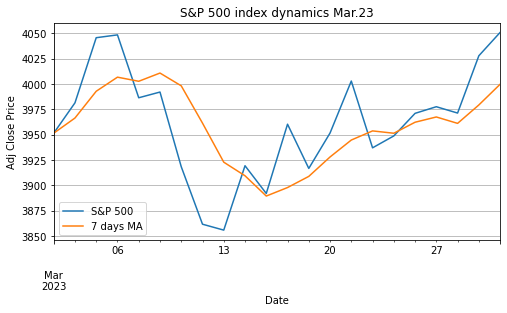

In [34]:
plt.figure(figsize=(8,4))
snp.loc['2023-03-01':, 'adj close'].plot(ylabel='Adj Close Price')
snp.loc['2023-03-01':, 'adj close'].rolling('7D').mean().plot()
plt.legend(['S&P 500', '7 days MA'])
plt.title('S&P 500 index dynamics Mar.23')
plt.grid(True)
plt.show()

In [35]:
snp_df = snp['2020-01-01':]
snp_df['symbol'] = len(snp_df)*['S&P']
snp_df = ts_features(snp_df, y='adj close', lag_orders=[7], ma_windows=[5]).add_features()
snp_df = snp_df[['adj close', 'lag_7_adj close', 'ma_5_lag_adj close']]

snp_train = snp_df['2020-01-01':'2023-03-28']['adj close'].to_frame()
snp_test = snp_df['2023-03-01':'2023-03-09']
snp_test2 = snp_df['2023-03-10':'2023-03-20']

In [36]:
%%time
model = pm.auto_arima(y=snp_train.values, start_p=1, start_q=1, d=1, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=7, max_q=7,
                     trace=False)

CPU times: user 2.62 s, sys: 1.78 s, total: 4.4 s
Wall time: 1.5 s


In [37]:
pred, conf = model.predict(n_periods=len(snp_test), return_conf_int=True)
snp_test['prediction'] = pred
snp_test['left_int'] = [i[0] for i in conf]
snp_test['right_int'] = [i[1] for i in conf]

print('ARIMA result:', evaluate_res(snp_test['adj close'], snp_test['prediction']))
print('Lags result', evaluate_res(snp_test['adj close'], snp_test['lag_7_adj close']))
print('MA with shift:', evaluate_res(snp_test['adj close'], snp_test['ma_5_lag_adj close']))

ARIMA result: {'RMSE': 46.618, 'MAE': 38.245, 'MAPE': 0.01}
Lags result {'RMSE': 58.425, 'MAE': 44.616, 'MAPE': 0.011}
MA with shift: {'RMSE': 80.263, 'MAE': 56.738, 'MAPE': 0.014}


In [38]:
forecasts = []
# confidence_intervals = []

for new_ob in snp_test['adj close'].values:
    fc, conf = model.predict(n_periods=1, return_conf_int=True)
    forecasts.append(fc[0])
#     confidence_intervals.append(conf)
    model.update(new_ob)
    
snp_test['1day_pred'] = forecasts

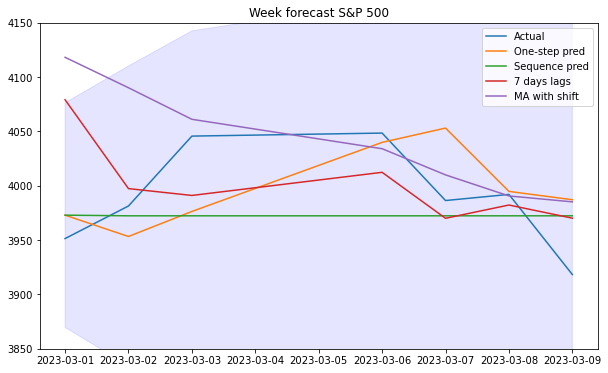

In [39]:
fig, ax = plt.subplots(figsize=(10,6))
ax.fill_between(x=snp_test.index, y1=snp_test['left_int'], y2=snp_test['right_int'], color='b', alpha=.1)
plt.plot(snp_test[['adj close', '1day_pred', 'prediction', 'lag_7_adj close', 'ma_5_lag_adj close']])
plt.legend(['Actual',  'One-step pred', 'Sequence pred', '7 days lags', 'MA with shift'])
plt.title(f"Week forecast S&P 500")
plt.ylim([3850,4150]);

#### Week 2 after updating first days

In [40]:
pred, conf = model.predict(n_periods=len(snp_test2), return_conf_int=True)
snp_test2['prediction'] = pred
snp_test2['left_int'] = [i[0] for i in conf]
snp_test2['right_int'] = [i[1] for i in conf]

print('ARIMA result:', evaluate_res(snp_test2['adj close'], snp_test2['prediction']))
print('Lags result', evaluate_res(snp_test2['adj close'], snp_test2['lag_7_adj close']))
print('MA with shift:', evaluate_res(snp_test2['adj close'], snp_test2['ma_5_lag_adj close']))

ARIMA result: {'RMSE': 40.93, 'MAE': 33.387, 'MAPE': 0.009}
Lags result {'RMSE': 101.247, 'MAE': 90.42, 'MAPE': 0.023}
MA with shift: {'RMSE': 89.043, 'MAE': 84.041, 'MAPE': 0.021}


In [41]:
forecasts = []
confidence_intervals = []

for new_ob in snp_test2['adj close'].values:
    fc, conf = model.predict(n_periods=1, return_conf_int=True)
    forecasts.append(fc[0])
    confidence_intervals.append(conf)
    model.update(new_ob)
    
snp_test2['1day_pred'] = forecasts

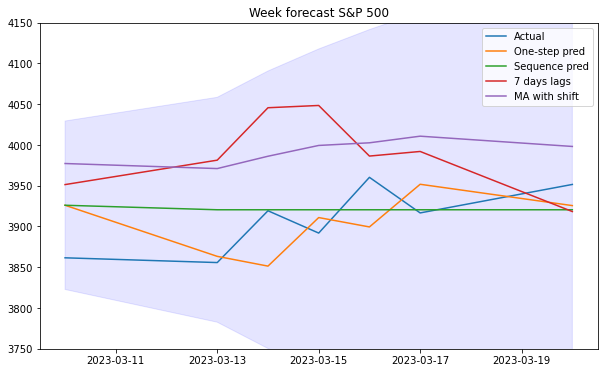

In [42]:
fig, ax = plt.subplots(figsize=(10,6))
ax.fill_between(x=snp_test2.index, y1=snp_test2['left_int'], y2=snp_test2['right_int'], color='b', alpha=.1)
plt.plot(snp_test2[['adj close', '1day_pred', 'prediction', 'lag_7_adj close', 'ma_5_lag_adj close']])
plt.legend(['Actual',  'One-step pred', 'Sequence pred', '7 days lags', 'MA with shift'])
plt.title(f"Week forecast S&P 500")
plt.ylim([3750,4150]);

#### Prediction of every stock

In [69]:
train = dff[['date', 'adj close', 'symbol']].set_index(keys='date')['2020-01-01':'2023-02-28'].dropna()
test = dff[['date', 'adj close', 'symbol']].set_index(keys='date')['2023-03-01':'2023-03-09'].dropna()
test2 = dff[['date', 'adj close', 'symbol']].set_index(keys='date')['2023-03-10':'2023-03-20'].dropna()

In [70]:
len(train), len(test)

(398174, 3521)

In [71]:
symbols = sorted(dff['symbol'].unique())
symb_names = fe.get_enc_dict()['symbol'].inverse_transform(symbols)
symb_enc_dict = dict(zip(symbols, symb_names))

In [72]:
models = []
y_pred = []
y_true = []
y_true2 = []
conf_int = []
symbol_list = []

for symb in tqdm(symbols):
    ts_train = train[train['symbol'] == symb]['adj close']
    ts_test = test[test['symbol'] == symb]['adj close']
    ts_test2 = test2[test2['symbol'] == symb]['adj close']
    y_true.append(ts_test)
    y_true2.append(ts_test2)
    symbol_list.append([symb]*len(ts_test))
    
    model = pm.auto_arima(y=ts_train.values, start_p=1, start_q=1, d=1, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=4, max_q=4,
                     race=False)
    models.append(model)
#     joblib.dump(model, f'ARIMA_models/arima_{symb_enc_dict[symb]}.pkl')
    
    pred, conf = model.predict(n_periods=len(ts_test), return_conf_int=True)
    y_pred.append(pred)
    conf_int.append(conf) 
    

100%|██████████| 503/503 [08:09<00:00,  1.03it/s]


In [73]:
true_vals = np.array(y_true).reshape(1,-1)[0]
pred_vals = np.array(y_pred).reshape(1,-1)[0]
evaluate_res(true_vals, pred_vals)

{'RMSE': 8.262, 'MAE': 3.447, 'MAPE': 0.022}

In [74]:
results_arima = []

for day in range(7):
    day_pred = [i[day] for i in y_pred]
    day_true = [j[day] for j in y_true]
    results_arima.append(evaluate_res(day_true, day_pred))

In [75]:
pd.DataFrame(data=results_arima, index=days).transpose()

,2023-03-01,2023-03-02,2023-03-03,2023-03-06,2023-03-07,2023-03-08,2023-03-09
RMSE,4.061,5.317,8.943,8.607,8.480,10.368,9.978
MAE,1.883,2.380,4.001,3.835,3.496,4.005,4.525
MAPE,0.012,0.016,0.024,0.022,0.022,0.024,0.031


In [76]:
a = pd.concat(y_true)
full = pd.DataFrame(data={'true_val': a}, index=a.index)
full['prediction'] = np.array(y_pred).reshape(1, -1)[0]
full['symbol'] = np.array(symbol_list).reshape(1,-1)[0]
full = full.replace({'symbol': symb_enc_dict})

sector_map = dff[['symbol', 'gics sector']].drop_duplicates().reset_index(drop=True)
sector_map['symbol'] = enc_dict['symbol'].inverse_transform(sector_map['symbol'])
sector_map['gics sector'] = enc_dict['gics sector'].inverse_transform(sector_map['gics sector'])
full = full.merge(sector_map, how='left', on='symbol').set_index(keys=a.index)

results_ar_sec = []
sectors = sorted(full['gics sector'].unique())
for sec in sectors:
    a = full[full['gics sector'] == sec]
    results_ar_sec.append(evaluate_res(a['true_val'], a['prediction']))
    
pd.DataFrame(data=results_ar_sec, index=sectors).sort_values(by='MAPE').transpose()

,Consumer Staples,Utilities,Real Estate,Industrials,Health Care,Materials,Information Technology,Communication Services,Financials,Consumer Discretionary,Energy
RMSE,2.296,1.425,3.433,5.778,9.114,3.512,8.339,4.366,5.026,18.566,3.965
MAE,1.542,1.061,2.050,3.301,4.714,2.421,4.303,2.285,2.961,6.515,2.828
MAPE,0.016,0.016,0.017,0.019,0.021,0.021,0.023,0.024,0.024,0.025,0.033


#### Week 2 after updating first days

In [78]:
%%time

predictions = []

for i in range(len(y_true)):
    models[i].update(y_true[i])
    pred = models[i].predict(n_periods=7, return_conf_int=False)
    predictions.append(pred)

CPU times: user 23.3 s, sys: 18.2 s, total: 41.6 s
Wall time: 11.5 s


In [79]:
true_vals = np.array(y_true2).reshape(1,-1)[0]
pred_vals = np.array(predictions).reshape(1,-1)[0]

evaluate_res(true_vals, pred_vals)

{'RMSE': 10.407, 'MAE': 5.153, 'MAPE': 0.039}